## Small network of LIF neurons (mode generic)
*NOTE: For several functions, variants can be tested by uncommenting commented lines.*

#### Imports and definitions

In [1]:
from brian2 import *
import brian2 as b2
print(f"Brian version: {b2.__version__}")
#BrianLogger.log_level_debug()
import matplotlib.pyplot as plt
# Matplotlib customization
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Standard value to scale model (variable can be used for fixed-pt. representation)
scf = 1
# Using Brian2Lava's standard model library and no specific library for other Lava processes
models_dir = None
lava_proc_dir = None

Brian version: 2.7.1


#### Select the backend for Brian / Brian2Lava

In [2]:
# The following are options for `set_device` (see the documentation for a detailed description)
device = "lava" # can be "lava", "cpp_standalone", "runtime", etc.
b2l_mode = "preset" # can be "preset" or "flexible"
b2l_hardware = "Loihi2" # can be "CPU" or "Loihi2"
b2l_num_repr = "fixed" # can be "float" or "fixed"
b2l_use_f2f = False # can be True (to use F2F converter) or False (to not use it)

#### Import Brian2Lava, set device, and prepare model (if required)

WARNING    The name of one (or more) models defined in the given model directory '/homes/jlubo/brian2lava-models/models' already exists in Brian2Lava's standard model library. Note that user-defined models will always override standard models. If you do not want this to happen, rename your model folder(s). [brian2lava.preset_mode.model_loader]


Brian2Lava version: 1.0.0b2

Preset LIF model:


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif                                                                             


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with exponentially decaying current input       


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


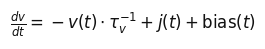

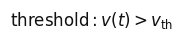

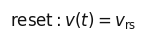



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                                              
bias : volt/second                                                              


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
----

In [3]:
# Using Brian2Lava device in Brian
if device == "lava":
    # Import Brian2Lava
    import brian2lava
    print(f"Brian2Lava version: {brian2lava.__version__}\n")
    # Select external models directory if Loihi 2 hardware is used
    # (replace this by your directory with ncProcessModels)
    if b2l_hardware == "Loihi2":
        models_dir = "/homes/jlubo/brian2lava-models/models"
        lava_proc_dir = "/homes/jlubo/brian2lava-models/lava_proc"
    # Set device
    set_device("lava", mode=b2l_mode, hardware=b2l_hardware, num_repr=b2l_num_repr, models_dir=models_dir, lava_proc_dir=lava_proc_dir, use_f2f=b2l_use_f2f)
    # Prepare model and print further information if in preset mode
    if b2l_mode == "preset":
        from brian2lava.preset_mode.model_loader import lif
        print(80*"=")
        print("Preset LIF model:\n"
              "=================\n\n")
        # This is a Brian equations object (check `type(lif.equations)`)
        #print(lif.equations)
        # This is a dictionary
        #for key, value in lif.conditions.items():
        #    print(f'{key} : {value}')
        #print("\n")
        # This is the standard function for human-friendly output of model information
        lif.show()
        print(80*"=")
        # Set scaling factors for fixed-point computation (should be leading to `dt >= 1`)
        if b2l_num_repr == "fixed":
            scf = 40000
# Using other device in Brian
else:
    # Set device
    set_device(device)

#### Set parameters

In [4]:
# General parameters
N          = 10             # number of neurons
delta_t    = 1*scf*ms       # duration of one timestep
t_max      = 120*scf*ms     # total duration of the simulation
bias       = 0*scf*mV/ms    # bias current added to every neuron

# Neuron and static synapse parameters
tau_v      = 10*scf*ms                   # membrane time constant
tau_j      = 5*scf*ms                    # synaptic time constant
v_rev      = -65.0*scf*mV                # intial/reversal membrane potential
v_rs       = -70*scf*mV                  # reset potential
v_th       = -55.0*scf*mV                # threshold potential
R_mem      = 10*scf*Mohm                 # membrane resistance
t_ax_delay = 3.0*scf*ms                  # axonal delay constant
# t_ref      = 2*scf*ms                  # refractory time
t_ref      = 0*scf*ms                    # refractory time
# j_0        = 0.15*scf*namp               # mean of input current
# sigma_wn   = 0.05*scf*namp*second**(1/2) # standard deviation of input current
j_0        = 0*scf*namp                  # mean of input current
sigma_wn   = 0*scf*namp*second**(1/2)    # standard deviation of input current
w_spike    = 6*scf*mV/delta_t            # input weight for spike generator (timestep-dependent)

# Set random seed
seed(1)

# Set defaultclock
defaultclock.dt = delta_t

#### Define LIF neuron and synapse model

In [5]:
# Neuron dynamics: Ornstein-Uhlenbeck input current and LIF membrane potential
neuron_eqs = '''
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                                              
bias : volt/second
'''
## Neuron dynamics: Ornstein-Uhlenbeck input current, LIF membrane potential, and exponential postsynaptic potentials
#neuron_eqs = '''
#dj/dt = ( -j + j_0 + sigma_wn*xi_j ) / tau_syn : amp
#dv/dt = ( -(v - v_rev) + v_psp + R_mem*j ) / tau_mem: volt (unless refractory)
#dv_psp/dt = -v_psp / tau_syn : volt
#'''

## Synapse dynamics: calcium amount, early-phase weight, pre- and postsynaptic events
#synapse_eqs = '''
#dCa/dt = -Ca/tau_Ca : 1 (clock-driven)
#dw/dt = ( 0.1*(w_0 - w) + gamma_p*(10*mV - w)*0.5*(1+sign(Ca - theta_p)) - gamma_d*w*0.5*(1+sign(Ca - theta_d)) + sqrt(tau_h * (0.5*(1+sign(Ca - theta_p)) + 0.5*(1+sign(Ca - theta_d)))) * sigma_pl * xi_pl ) / tau_h : volt (clock-driven)
#'''
#synapse_pre = {
#'pre_voltage': 'v_psp_post += w',
#'pre_calcium': 'Ca += Ca_pre'
#}
#synapse_post='''Ca += Ca_post'''

#### Add neurons, synapses, and spike generation

In [6]:
# Rescale voltage values to get rid of `v_rev` (currently not available in preset LIF model)
v_rs = v_rs - v_rev
v_th = v_th - v_rev

# Add neuron group
P = NeuronGroup(N, 
                neuron_eqs, 
                threshold='v>v_th', 
                reset='v=v_rs', 
                refractory=t_ref, 
                method='euler') # or: method='heun'
# Initialize membrane potential at reversal potential
#P.v = v_rev
P.v = 0*mvolt
# Set different initial input currents for selected neurons
#P.j[2:] = '20*(10+rand())*volt/second' # depending on random number

## Add synapses within neuron group
#S_P = Synapses(P, P, 
#               model=synapse_eqs, 
#               on_pre=synapse_pre, 
#               on_post=synapse_post, 
#               method='heun')
## Create connection neuron 1 -> neuron 0
#S_P.connect(i=1, j=0)
## Set initial connection weight
#S_P.w = w_0
#S_P.Ca = 0
#S_P.pre_voltage.delay = t_ax_delay
#S_P.pre_calcium.delay = t_Ca_delay # TODO

# Add spike generator
# Spike times and indices
spike_gen_times_1 = np.array([10, 20, 30, 40, 50, 60, 100])
spike_gen_times_rand = 20*np.random.default_rng(1).uniform(1, 2, N-1)
spike_gen_times = np.concatenate((spike_gen_times_1, spike_gen_times_rand))*scf*ms
spike_gen_indices = np.concatenate(([0]*len(spike_gen_times_1), range(1, N)))
# Create spike-generating neurons
SG = SpikeGeneratorGroup(N, spike_gen_indices, spike_gen_times)
# Connect to neuron 1 in population `P`
#S_SG_P = Synapses(SG, P, on_pre='''v_post+=w_spike''') # TODO
S_SG_P = Synapses(SG, P, model='w : volt/second', on_pre='''j_post+=w''')
#S_SG_P.connect(i=0, j=1)
#S_SG_P.connect(j='i+1', skip_if_invalid=True)
S_SG_P.connect(j='i')
S_SG_P.w = w_spike

#### Add monitors

In [7]:
# Add monitor for spikes
spm = SpikeMonitor(P)

# Add monitor for membrane voltage
stm_P_v = StateMonitor(P, variables='v', record=True)

# Add monitor for postsynaptic current
stm_P_c = StateMonitor(P, variables='j', record=[0])

# Add monitor for synaptic variables
#stm_S_P = StateMonitor(S_P, variables=['w', 'Ca'], record=True) #, dt=delta_t_sample)

WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compared to Brian 2, 
        where the 'record' parameter only accepts boolean values). Otherwise, all elements are monitored regardless of the 
        specified indices, and filtering is done only as a post-processing step - thus, no performance gain will come from it. [brian2.devices.lava]


#### Run simulation

In [8]:
# Run simulation
run(t_max)

WARNING    'bias' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0. * volt / second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       Selected preset model 'lif' for 'neurongroup'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_j' in Lava process: Assuming that this is a decay constant. Now looking in Brian script for according decay time constant 'tau_j'. [brian2.devices.lava]
INFO       Encountered variable named 'delta_v' in Lava process: Assuming that this is a decay constant. Now looking in Brian script for according decay time constant 'tau_v'. [brian2.devices.lava]
WARNING    Variable or parameter 'bias_exp' was not defined. The default value 0 from Process is used. [brian2.devices.lava]
INFO       For synapses, Brian2Lava currently only supports the 'on_pre' condition, with code of the type 'x+=w', where 'x' is the postsynaptic variable to be affected (

ucode_neuron cmd='/homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/ucode_compiler/bin/dend_asm /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.cpp /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.ucb > /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.dat 2> /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.err'


INFO       Retrieving monitor values [brian2.devices.lava]
INFO       Successfully retrieved monitor values [brian2.devices.lava]
INFO       Updating Brian variables [brian2.devices.lava]
WARNING    The value of variable 'bias' cannot be updated. Reading out variables in mantissa-and-exponent representation is not seamlessly possible from microcode. [brian2.devices.lava]
INFO       Successfully updated Brian variables [brian2.devices.lava]


#### Plot membrane potential of selected neurons

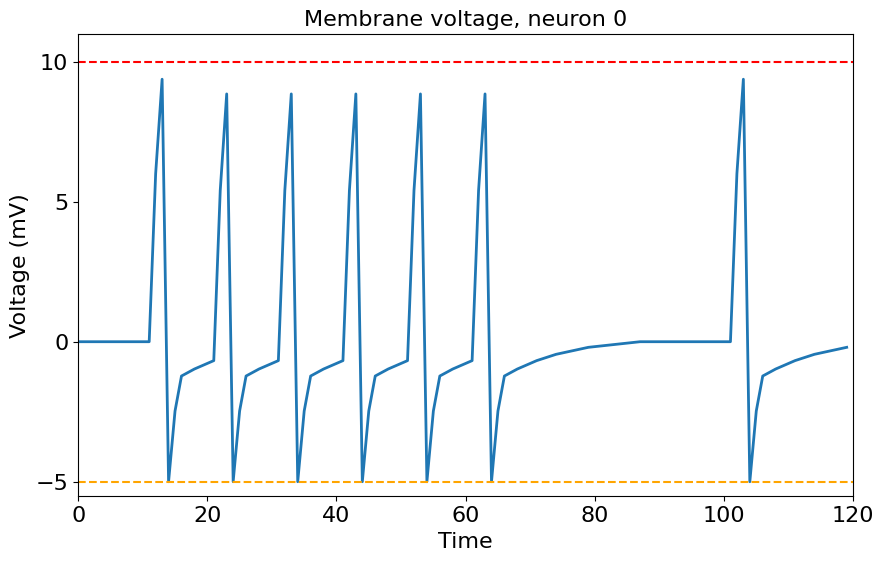

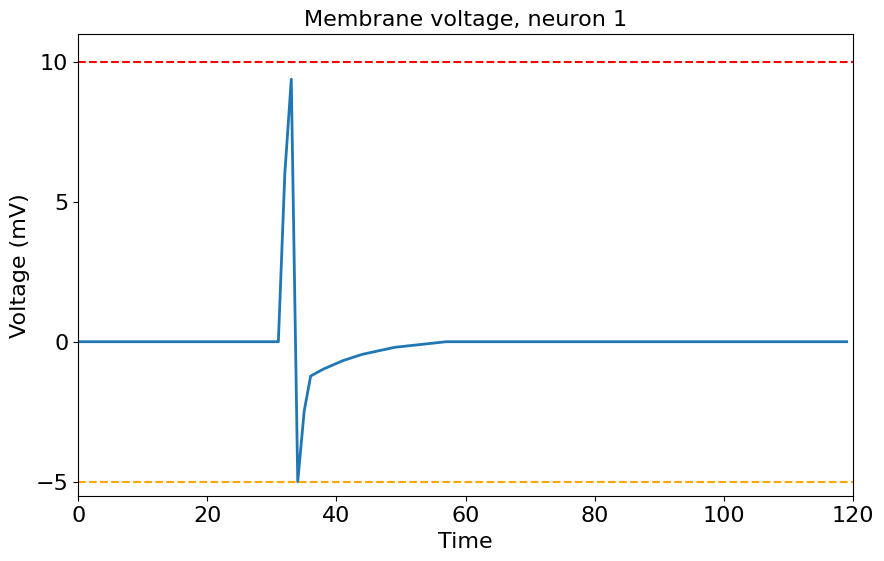

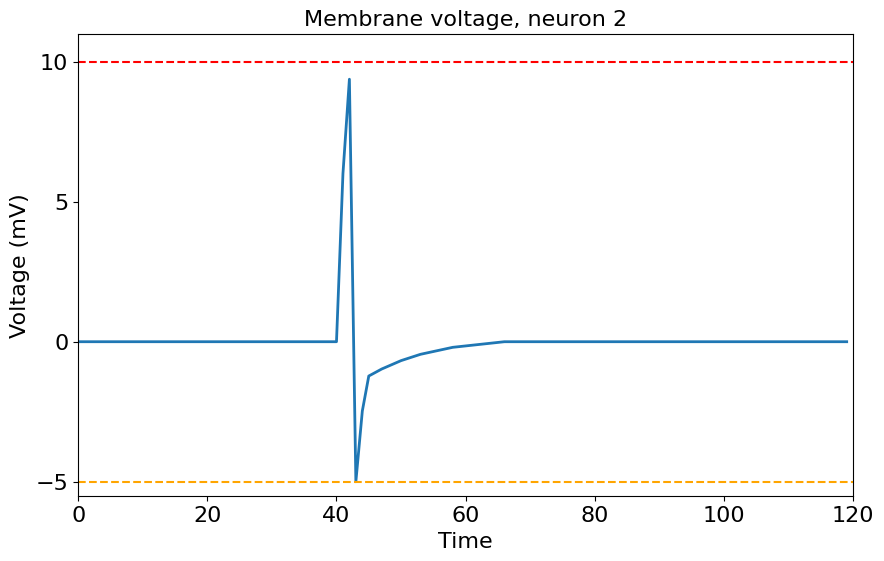

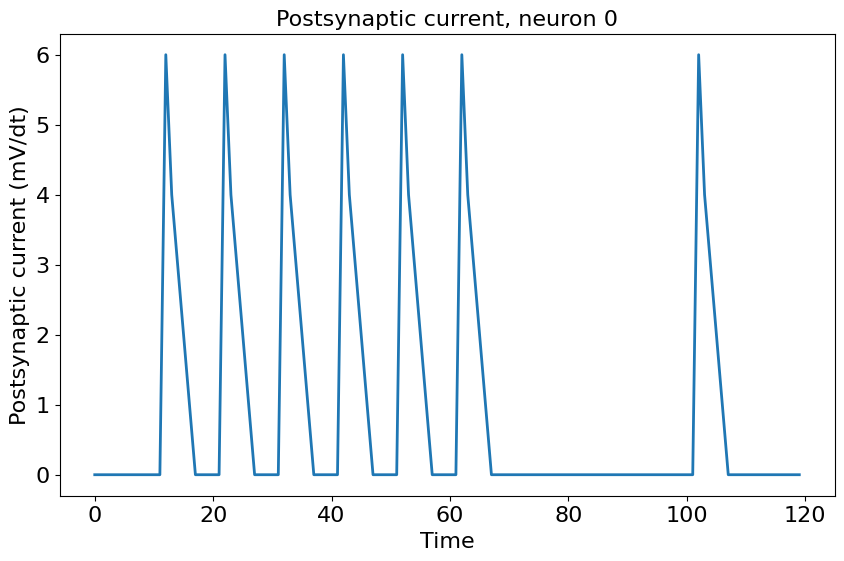

In [9]:
# Plot the voltage time course of specific neurons `nn`
for nn in [0, 1, 2]:
    t = stm_P_v.t/(scf*ms)
    v = stm_P_v.v[nn]/(scf*mV)
    plt.figure(figsize=(10,6))
    plt.plot(t, v, linewidth=2)
    #print(f"max(v) = {np.max(v)}")
    #print(f"min(v) = {np.min(v)}")
    plt.axhline(y=v_rs/(scf*mV), color='orange', linestyle='dashed', linewidth=1.5)
    plt.axhline(y=v_th/(scf*mV), color='red', linestyle='dashed', linewidth=1.5)
    plt.title(f'Membrane voltage, neuron {nn}')
    plt.yticks(np.linspace(v_rs/(scf*mV), v_th/(scf*mV), 4))
    plt.xlim((0, t_max/(scf*ms)))
    plt.ylim((1.1*v_rs/(scf*mV),1.1*v_th/(scf*mV)))
    plt.xlabel('Time')
    plt.ylabel('Voltage (mV)')
    plt.show()

# Plot the PSC time course of specific neurons `nn`
for nn in [0]:
    t = stm_P_c.t/(scf*ms)
    c = stm_P_c.j[nn]/(scf*mV/delta_t)
    plt.figure(figsize=(10,6))
    plt.plot(t, c, linewidth=2)
    plt.title(f'Postsynaptic current, neuron {nn}')
    plt.xlabel('Time')
    plt.ylabel('Postsynaptic current (mV/dt)')
    plt.show()

#### Plot time course of selected synapses

In [10]:
## Plot the time course of specific synapses `syn`
#for syn in [0]:
#    # Plot the time course of calcium of selected synapse `syn`
#    t = stm_S_P.t/ms
#    w = stm_S_P.w[syn]
#    Ca = stm_S_P.Ca[syn]
#    plt.figure(figsize=(10,6))
#    plt.plot(t, Ca, color='#c8c896', linewidth=2)
#    plt.axhline(y=theta_p, color='#969664', label=r'$\theta$_p', linestyle='dashed', linewidth=1.5)
#    plt.axhline(y=theta_d, color='#969696', label=r'$\theta$_d', linestyle='dashed', linewidth=1.5)
#    plt.title(f'Calcium amount, synapse {syn}')
#    #plt.yticks(np.linspace(0, 2*theta_p, 5))
#    plt.xlim((0, t_max/ms))
#    plt.ylim((-0.10, 4.10))
#    plt.xlabel('Time (ms)')
#    plt.ylabel('Calcium (arbitary units)')
#    plt.show()
#
#    # Plot the time course of the early-phase weight of selected synapse `syn`
#    plt.figure(figsize=(10,6))
#    plt.plot(t, w/w_0*100, color="#800000", linewidth=2)
#    plt.title(f'Early-phase synaptic weight, synapse {syn}')
#    #plt.yticks(np.linspace(0, 200, 5))
#    plt.xlim((0, t_max/ms))
#    plt.ylim((98.5, 105.5))
#    plt.xlabel('Time (ms)')
#    plt.ylabel('Synaptic weight (%)')
#    plt.show()

#### Plot spikes of all neurons

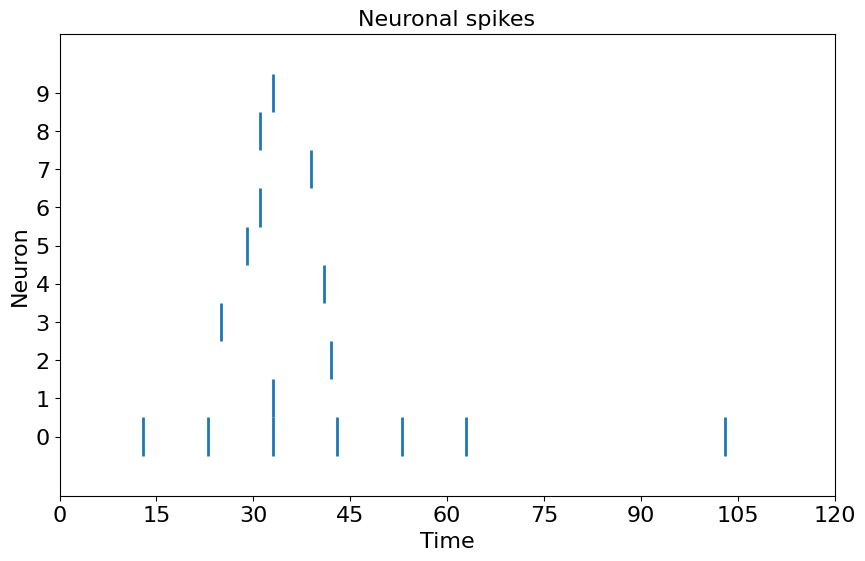

Total number of spikes: 16


In [11]:
# Plot the spike raster
spike_times = [spm.t[spm.i == i]/(scf*ms) for i in range(N)]

plt.figure(figsize=(10,6))
plt.eventplot(spike_times, linewidth=2)
plt.title('Neuronal spikes')
plt.xticks(np.arange(0, t_max/(scf*ms)+1, t_max/(scf*ms)/8))
plt.yticks(np.arange(0, N))
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

# Print the number of spikes
print(f"Total number of spikes: {len(spm.i)}")

#### Store data for later comparison
Comparison can be done using `*_compare.ipynb`

In [12]:
data_dir = "lif_small_network_generic"
data_file = device
if device == "lava":
    data_file += f"-{b2l_mode}-{b2l_hardware}-{b2l_num_repr}"
np.save(f'{data_dir}/v_{data_file}.npy', np.vstack([t, (stm_P_v.v+v_rev)/(scf*mV)]), allow_pickle=True)
#np.save(f'{data_dir}/w_{data_file}.npy', np.vstack([t, stm_S_P.w/w_0]), allow_pickle=True)
#np.save(f'{data_dir}/Ca_{data_file}.npy', np.vstack([t, stm_S_P.Ca]), allow_pickle=True)# "Loihi2" backend does not support spike monitors yet
np.savez(f'{data_dir}/spikes_{data_file}.npz', *spike_times, allow_pickle=True)